## List processing study

At the end of Section 3.2. of the [RTG-AE paper](https://arxiv.org/abs/2012.02097), we mention that we recommend using GRUs to decode lists instead of using a feedforward layer. In this notebook, we will provide empirical evidence for this recommendation. To do so, we evaluate a simpler grammar which represents lists of binary numbers, namely $\mathcal{G} = (\Phi, \Sigma, R, S)$ where
\begin{align}
\Phi = \{&S, B\}, \\
\Sigma = \{&\oplus, \#, 0, 1\}, \\
R = \{& S \to \oplus(B, S), S \to \#(B), B \to 0, B \to 1 \}
\end{align}
and where $\oplus$ expresses list concatenation.

Our data set consists of all lists of the form `1`, `01`, `001`, `0001`, and so on until a maximum number of zeros. To represent this data set, the model needs to encode the length of the list and decode a lot of zeros before stopping. This task is particularly difficult for the default version of RTG-AE because the model can easily be caught in an endless loop, where it just generates an endless sequence of zeros. This problem can be alleviated by using a GRU for decoding instead of a feedforward layer.

In this notebook, we compare a vanilla RTG-AE versus one that replaces the feedforward layer for the decoding of $S \to :(B, S)$ with a GRU. We will notice that the vanilla RTG-AE will be caught in an endless loop, whereas the GRU variant won't.

In [1]:
task = 'list_encoding'

import numpy as np
import tree
import tree_grammar

alphabet = {'list' : 2, 'list_end' : 1, '0' : 0, '1' : 0}
nonts = ['S', 'B']
start = 'S'
rules = { 'S' : [('list', ['B', 'S']), ('list_end', ['B'])], 'B' : [('0', []), ('1', [])]}
grammar = tree_grammar.TreeGrammar(alphabet, nonts, start, rules)

import recursive_tree_grammar_auto_encoder as rtg_ae
from single_step_gru import SingleStepGRU
# the number of neurons for all models; this is taken from Kusner's
# https://github.com/mkusner/grammarVAE/blob/master/models/model_eq.py
dim = 100
# the encoding dimensionality for the variational auto-encoder
dim_vae  = 8

rtgae = rtg_ae.TreeGrammarAutoEncoder(grammar, dim = dim, dim_vae = dim_vae)

rtgae_with_gru = rtg_ae.TreeGrammarAutoEncoder(grammar, dim = dim, dim_vae = dim_vae)
rtgae_with_gru._dec._rules['S'][0]._child_layers[1] = SingleStepGRU(dim)
models = [rtgae, rtgae_with_gru]
model_names = ['rtgae', 'rtgae_with_gru']

# generate data
max_len = 30
trees = []
for l in range(1, max_len + 1):
    root    = tree.Tree('list')
    parent  = root
    for i in range(l-1):
        # choose next symbol
        parent._children.append(tree.Tree('1'))
        # continue the list
        child = tree.Tree('list')
        parent._children.append(child)
        parent = child
    # set last node
    parent._label = 'list_end'
    parent._children.append(tree.Tree('0'))
    trees.append(root.to_list_format())

/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# the number of training epochs
T = 3125
# the learning rate
learning_rate = 1E-3
# the L2 regularization strength
weight_decay = 0

avg_factor = .1
print_step = 100

hyperparams = [(1., 1E-5), (1E-2, 1E-2)]

In [3]:
import torch
import edist.ted as ted
# train both models
errors = np.zeros((len(models), len(trees)))
learning_curves = np.zeros((len(models), T))
for model_idx in range(len(models)):
    print('--- %s ---' % model_names[model_idx])
    model = models[model_idx]
    beta, sigma_scaling = hyperparams[model_idx]

    # set up the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # start training
    avg_loss = None
    for epoch in range(1, T + 1):
        optimizer.zero_grad()
        # compute error over all trees
        minibatch_loss = 0.
        for j in range(len(trees)):
            nodes, adj = trees[j]
            # compute loss
            loss = model.compute_loss(nodes, adj, beta = beta, sigma_scaling = sigma_scaling)
            minibatch_loss += loss.item()
            # compute gradient
            loss.backward()
        # perform an optimizer step
        optimizer.step()
        # update the moving loss average
        minibatch_loss /= len(trees)
        learning_curves[model_idx, epoch-1] += minibatch_loss
        if avg_loss is None:
            avg_loss = minibatch_loss
        else:
            avg_loss = (1. - avg_factor) * avg_loss + avg_factor * minibatch_loss
        if(epoch % print_step == 0):
            print('loss avg after %d epochs: %g' % (epoch, avg_loss))
    # evaluate error
    for j in range(len(trees)):
        nodes, adj = trees[j]
        _, z = model.encode(nodes, adj)
        nodes_act, adj_act, _ = model.decode(z, max_size = 2 * len(trees))
        errors[model_idx, j]  = ted.ted(nodes, adj, nodes_act, adj_act)

--- rtgae ---
loss avg after 100 epochs: 0.189859
loss avg after 200 epochs: 0.183444
loss avg after 300 epochs: 0.30742
loss avg after 400 epochs: 0.126344
loss avg after 500 epochs: 0.137033
loss avg after 600 epochs: 0.112857
loss avg after 700 epochs: 0.104677
loss avg after 800 epochs: 0.0740849
loss avg after 900 epochs: 0.0728237
loss avg after 1000 epochs: 0.0552798
loss avg after 1100 epochs: 0.107351
loss avg after 1200 epochs: 0.0758248
loss avg after 1300 epochs: 0.0422942
loss avg after 1400 epochs: 0.0377245
loss avg after 1500 epochs: 0.0272612
loss avg after 1600 epochs: 0.0346021
loss avg after 1700 epochs: 0.0780656
loss avg after 1800 epochs: 0.0604755
loss avg after 1900 epochs: 0.0457984
loss avg after 2000 epochs: 0.0385154
loss avg after 2100 epochs: 0.0340922
loss avg after 2200 epochs: 0.036624
loss avg after 2300 epochs: 0.0310512
loss avg after 2400 epochs: 0.0337852
loss avg after 2500 epochs: 0.03464
loss avg after 2600 epochs: 0.0296348
loss avg after 2700

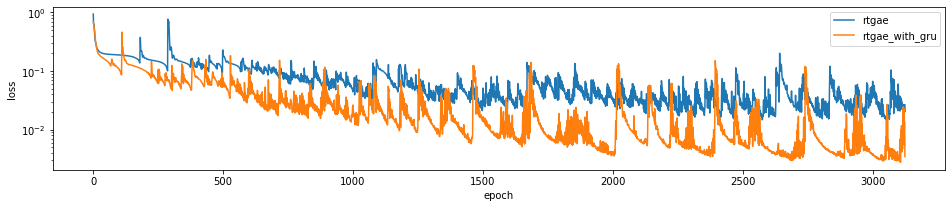

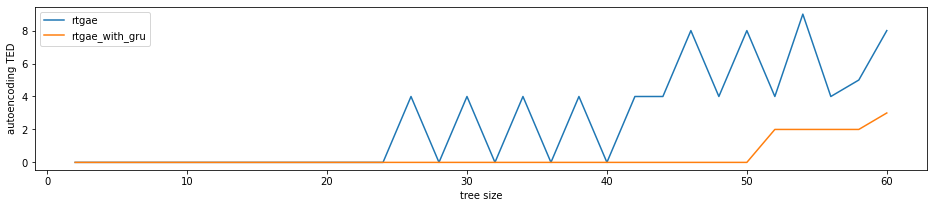

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16,3))
plt.semilogy(learning_curves.T)
plt.legend(model_names)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

np.savetxt('results/%s_learning_curves.csv' % task, learning_curves.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')

plt.figure(figsize = (16,3))
for model_idx in range(len(models)):
    plt.plot(2 * np.arange(1, len(trees) + 1), errors[model_idx, :])
plt.legend(model_names)
plt.xlabel('tree size')
plt.ylabel('autoencoding TED')
plt.show()

np.savetxt('results/%s_errors.csv' % task, errors.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')

In [5]:
# illustrate the endless loop phenomenon
j = np.argmax(errors[0, :])

nodes, adj = trees[j]
_, z = models[0].encode(nodes, adj)
nodes_act, adj_act, _ = models[0].decode(z, max_size = 2 * len(trees))

print('original tree: %s' % tree.tree_to_string(nodes, adj))
print('auto-encoded tree: %s' % tree.tree_to_string(nodes_act, adj_act))

original tree: list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list_end(0)))))))))))))))))))))))))))
auto-encoded tree: list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, list(1, S))))))))))))))))))))))))))))))
